In [31]:
# --- Setup / Imports / Helpers ---

import pandas as pd
import matplotlib.pyplot as plt

def load_data(csv_path="logs.csv"):
    """Load logs from disk and return a fresh dataframe."""
    df = pd.read_csv(csv_path)
    return df

def summarize_experiment_1(df):
    """
    Return summary stats for KV cache ON vs OFF.
    Groups by use_cache and computes throughput, latency, and memory.
    """
    return df.groupby("use_cache")[["tokens_per_s",
                                    "p50_latency_s",
                                    "p95_latency_s",
                                    "peak_mem_mb"]].mean()

def summarize_experiment_2(df):
    """
    Return summary stats by batch size, but only for runs with cache ON.
    """
    df_batch = df[df["use_cache"] == 1]
    return df_batch.groupby("batch_size")[["tokens_per_s",
                                           "p95_latency_s",
                                           "peak_mem_mb"]].mean()
def summarize_experiment_3(df):
    """
    Return summary stats grouped by prompt_len
    (only cache ON, batch_size=1).
    We look at latency (p50) and memory.
    """
    df_len = df[(df["use_cache"] == 1) & (df["batch_size"] == 1)]
    return df_len.groupby("prompt_len")[["p50_latency_s",
                                         "p95_latency_s",
                                         "peak_mem_mb"]].mean()


In [32]:
# --- Load the current experimental data ---
df = load_data()

display(df)


,model,dtype,device,use_cache,batch_size,prompt_len,max_new_tokens,total_time_s,tokens_generated,tokens_per_s,p50_latency_s,p95_latency_s,peak_mem_mb
0,distilgpt2,float16,cuda,1,1,64,128,0.735708,128,173.981951,0.005457,0.007176,183.155762
1,distilgpt2,float16,cuda,0,1,64,128,0.703022,128,182.071142,0.005112,0.006976,179.798340
2,distilgpt2,float16,cuda,1,1,64,128,0.712523,128,179.643198,0.005264,0.007072,183.155762
3,distilgpt2,float16,cuda,1,2,64,128,0.711656,256,359.724210,0.005235,0.007331,192.676758
4,distilgpt2,float16,cuda,1,4,64,128,0.792793,512,645.817932,0.006096,0.007373,212.611328
5,distilgpt2,float16,cuda,1,1,32,128,0.743029,128,172.267839,0.005454,0.007298,180.925293
6,distilgpt2,float16,cuda,1,1,128,128,0.759880,128,168.447561,0.005415,0.007512,185.710449
7,distilgpt2,float16,cuda,1,1,256,128,0.665167,128,192.432878,0.004931,0.006048,192.724121


## Experiment 1 - With and Without KV-Cache

Experiment 1 – Raw rows (cache ON vs OFF):


,model,dtype,device,use_cache,batch_size,prompt_len,max_new_tokens,tokens_per_s,p50_latency_s,p95_latency_s,peak_mem_mb
0,distilgpt2,float16,cuda,1,1,64,128,173.981951,0.005457,0.007176,183.155762
1,distilgpt2,float16,cuda,0,1,64,128,182.071142,0.005112,0.006976,179.798340
2,distilgpt2,float16,cuda,1,1,64,128,179.643198,0.005264,0.007072,183.155762
3,distilgpt2,float16,cuda,1,2,64,128,359.724210,0.005235,0.007331,192.676758
4,distilgpt2,float16,cuda,1,4,64,128,645.817932,0.006096,0.007373,212.611328
5,distilgpt2,float16,cuda,1,1,32,128,172.267839,0.005454,0.007298,180.925293
6,distilgpt2,float16,cuda,1,1,128,128,168.447561,0.005415,0.007512,185.710449
7,distilgpt2,float16,cuda,1,1,256,128,192.432878,0.004931,0.006048,192.724121



Experiment 1 – Grouped summary by use_cache:


,tokens_per_s,p50_latency_s,p95_latency_s,peak_mem_mb
use_cache,,,,
0,182.071142,0.005112,0.006976,179.798340
1,270.330795,0.005407,0.007116,190.137068


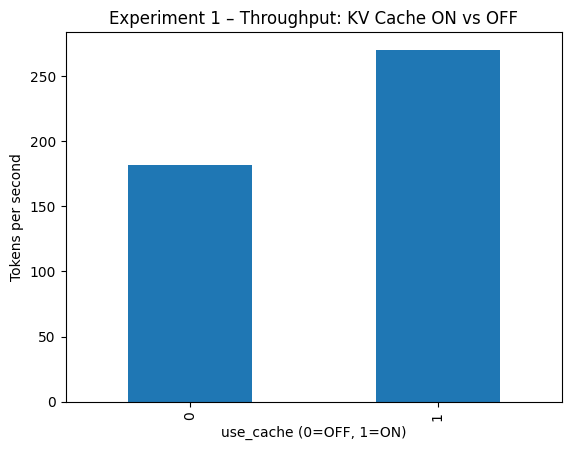

In [ ]:
# === Experiment 1 – KV Cache ON vs OFF ===

print("Experiment 1 – Raw rows (cache ON vs OFF):")
display(df[["model",
            "dtype",
            "device",
            "use_cache",
            "batch_size",
            "prompt_len",
            "max_new_tokens",
            "tokens_per_s",
            "p50_latency_s",
            "p95_latency_s",
            "peak_mem_mb"]])

print("\nExperiment 1 – Grouped summary by use_cache:")
exp1_summary = summarize_experiment_1(df)
display(exp1_summary)

# Throughput bar plot
exp1_summary["tokens_per_s"].plot.bar(
    title="Experiment 1 – Throughput: KV Cache ON vs OFF"
)
plt.ylabel("Tokens per second")
plt.xlabel("use_cache (0=OFF, 1=ON)")
plt.show()


## Experiment 2 - Batching Effect

Experiment 2 – Raw rows (cache ON, varying batch_size):


,batch_size,prompt_len,max_new_tokens,tokens_per_s,p95_latency_s,peak_mem_mb
0,1,64,128,173.981951,0.007176,183.155762
2,1,64,128,179.643198,0.007072,183.155762
3,2,64,128,359.724210,0.007331,192.676758
4,4,64,128,645.817932,0.007373,212.611328
5,1,32,128,172.267839,0.007298,180.925293
6,1,128,128,168.447561,0.007512,185.710449
7,1,256,128,192.432878,0.006048,192.724121



Experiment 2 – Grouped summary by batch_size:


,tokens_per_s,p95_latency_s,peak_mem_mb
batch_size,,,
1,177.354685,0.007021,185.134277
2,359.724210,0.007331,192.676758
4,645.817932,0.007373,212.611328


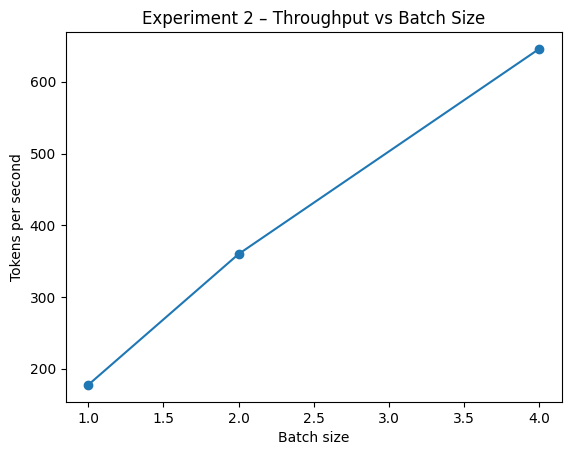

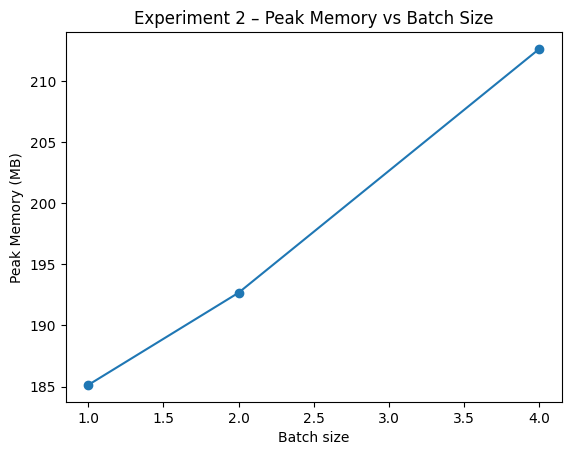

In [ ]:
# === Experiment 2 – Batch Size Scaling ===


# Keep only cache-on runs
df_batch = df[df["use_cache"] == 1]

print("Experiment 2 – Raw rows (cache ON, varying batch_size):")
display(df_batch[["batch_size",
                  "prompt_len",
                  "max_new_tokens",
                  "tokens_per_s",
                  "p95_latency_s",
                  "peak_mem_mb"]])

print("\nExperiment 2 – Grouped summary by batch_size:")
exp2_summary = summarize_experiment_2(df)
display(exp2_summary)

# Throughput scaling
exp2_summary["tokens_per_s"].plot(
    marker="o",
    title="Experiment 2 – Throughput vs Batch Size"
)
plt.ylabel("Tokens per second")
plt.xlabel("Batch size")
plt.show()

# Memory scaling
exp2_summary["peak_mem_mb"].plot(
    marker="o",
    title="Experiment 2 – Peak Memory vs Batch Size"
)
plt.ylabel("Peak Memory (MB)")
plt.xlabel("Batch size")
plt.show()


## Experiment 3 – Cache Scaling with Sequence Length
We vary the initial prompt length (32, 128, 256 tokens) with batch_size=1 and KV cache ON.
We examine how memory usage and per-token latency change as context length increases.

Experiment 3 – Raw rows (cache ON, batch_size=1, varying prompt_len):


,prompt_len,batch_size,max_new_tokens,p50_latency_s,p95_latency_s,peak_mem_mb
0,64,1,128,0.005457,0.007176,183.155762
2,64,1,128,0.005264,0.007072,183.155762
5,32,1,128,0.005454,0.007298,180.925293
6,128,1,128,0.005415,0.007512,185.710449
7,256,1,128,0.004931,0.006048,192.724121



Experiment 3 – Grouped summary by prompt_len:


,p50_latency_s,p95_latency_s,peak_mem_mb
prompt_len,,,
32,0.005454,0.007298,180.925293
64,0.005360,0.007124,183.155762
128,0.005415,0.007512,185.710449
256,0.004931,0.006048,192.724121


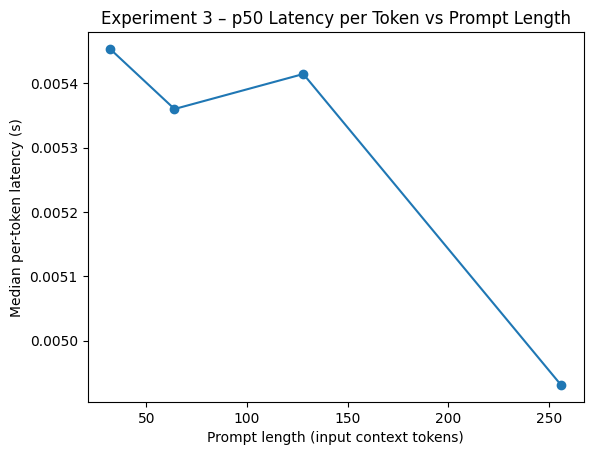

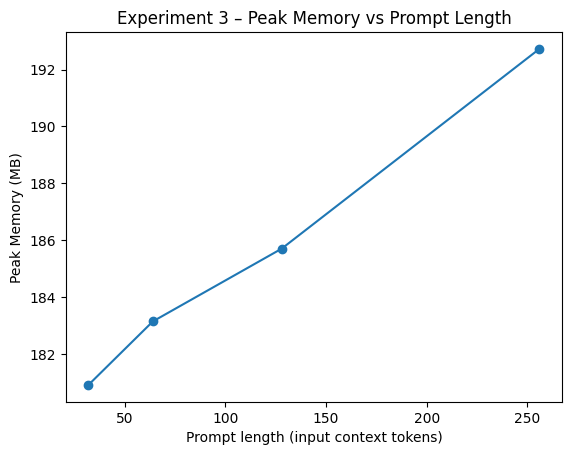

In [ ]:
# === Experiment 3 – Prompt Length Scaling ===

# Make sure we’re looking at cache=ON, batch_size=1
df_len = df[(df["use_cache"] == 1) & (df["batch_size"] == 1)]

print("Experiment 3 – Raw rows (cache ON, batch_size=1, varying prompt_len):")
display(df_len[["prompt_len",
                "batch_size",
                "max_new_tokens",
                "p50_latency_s",
                "p95_latency_s",
                "peak_mem_mb"]])

print("\nExperiment 3 – Grouped summary by prompt_len:")
exp3_summary = summarize_experiment_3(df)
display(exp3_summary)

# Plot latency vs prompt_len
exp3_summary["p50_latency_s"].plot(
    marker="o",
    title="Experiment 3 – p50 Latency per Token vs Prompt Length"
)
plt.ylabel("Median per-token latency (s)")
plt.xlabel("Prompt length (input context tokens)")
plt.show()

# Plot memory vs prompt_len
exp3_summary["peak_mem_mb"].plot(
    marker="o",
    title="Experiment 3 – Peak Memory vs Prompt Length"
)
plt.ylabel("Peak Memory (MB)")
plt.xlabel("Prompt length (input context tokens)")
plt.show()

